# Installing necessary dependencies

In [1]:
# %pip install -Uq 'unstructured[pdf]' pillow lxml
# %pip install -Uq chromadb tiktoken redis
# %pip install -Uq langchain langchain-community langchain-anthropic langchain-groq
# %pip install -Uq python-dotenv

# Data extraction

Extract the element of the PDF. Could be: Text, Images, Tables, etc.

In [2]:
from unstructured.partition.pdf import partition_pdf

OUTPUT_PATH = './pdf/'
FILEPATH = OUTPUT_PATH + 'Photography-101-Pocket-Guide.pdf'

chunks = partition_pdf(
    filename=FILEPATH,
    extract_image_block_types=['Image'],
    extract_image_block_to_payload=True, # if True, will extract base64
    chunking_strategy='by_title', # 'by_title' or 'basic'
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000
)

In [3]:
print(f'Total data chunk: {len(chunks)}')

Total data chunk: 15


View the first element of the chunk

In [4]:
first_element = chunks[0].metadata.orig_elements
first_element

Preview the extracted image from first element

In [5]:
chunk_images = [el for el in first_element if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '607f7161-2e34-4250-8561-158db4aaa675',
 'text': '',
 'metadata': {'detection_class_prob': 0.3660457134246826,
  'coordinates': {'points': ((9.422920227050781, 531.5744018554688),
    (9.422920227050781, 1219.516845703125),
    (707.4541015625, 1219.516845703125),
    (707.4541015625, 531.5744018554688)),
   'system': 'PixelSpace',
   'layout_width': 700,
   'layout_height': 1025},
  'last_modified': '2025-01-02T13:05:57',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 1,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAKwAroDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWm

Display the image example

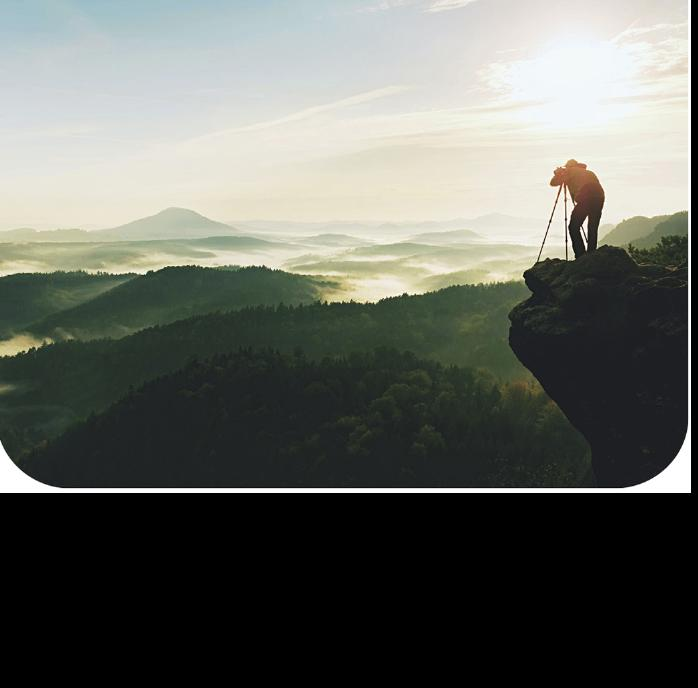

In [6]:
import base64
from IPython.display import display, Image

def display_base64(base64_code):
    image_data = base64.b64decode(base64_code)
    display(Image(image_data))

display_base64(chunk_images[0].to_dict()['metadata']['image_base64'])

Get separate extracted text and images

In [7]:
def extract_images_from_chunk(chunks):
    images = []
    for chunk in chunks:
        elements = chunk.metadata.orig_elements
        for el in elements:
            if 'Image' in str(type(el)):
                images.append(el.metadata.image_base64)
    return images
    

texts = [chunk for chunk in chunks if 'CompositeElement' in str(type(chunk))]
images = extract_images_from_chunk(texts)

In [8]:
print(f'Total text chunk: {len(texts)}')
print(f'Total image chunk: {len(images)}')

Total text chunk: 15
Total image chunk: 41


# Summarize the data

In [9]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

RAW_PROMPT_TEXT = """Summarize the following text in a concise, relevant manner. 
Do not provide any introduction, explanation, disclaimers, or personal remarks. 
Only present the summarized content. 
Use the text below as your source material, and respond with the condensed version of that text alone, without additional context or commentary.

Text chunk: 
{element}
"""

PROMPT_TEXT = ChatPromptTemplate.from_template(RAW_PROMPT_TEXT)

# text summary chain
text_summarizer = ChatGroq(model="llama-3.1-8b-instant", temperature=0.5, api_key=os.getenv('GROQ_API_KEY'))
summarize_chain = PROMPT_TEXT | text_summarizer | StrOutputParser()

### Text summary

In [10]:
text_summarize = summarize_chain.batch(texts, {'max_concurrency': 3})

In [11]:
print(f'Total text summary: {len(text_summarize)}')
text_summarize

Total text summary: 15


['01 PRE-SHOOT CHECKLIST\n\n02 EXPOSURE BASICS\n\n- Aperture and Depth of Field\n- Shutter Speed and Motion\n- ISO and Noise\n- Stops\n\n03 SETTING UP YOUR CAMERA\n\n- Exposure/Shooting Modes\n- Metering Modes\n- Exposure Compensation\n- Focus Area & Focus Modes\n- Release/Drive Modes\n- White Balance\n- Highlight Warning (“Blinkies”)\n- Noise Reduction\n- File Formats and File Sizes\n- Picture Controls/Styles/Film Simulations\n- Color Spaces\n\n04 LENSES AND FOCAL LENGTH\n\n- Focal Lengths\n- Constant Aperture Lenses\n- Variable Aperture Lenses\n- Lens Compression and Distortion\n- Focal Length, Camera Shake, and Shutter Speed',
 '05 ADVANCED SHOOTING TECHNIQUES\n- AUTO ISO\n- BACK BUTTON FOCUS\n- FOCUS AND COMPOSITION\n- EXPOSURE BRACKETING/HDR PHOTOGRAPHY\n- USING THE HISTOGRAM\n\n06 COMPOSITION TIPS\n- RULE OF THIRDS\n- FILL THE FRAME\n- NEGATIVE SPACE\n- LEADING LINES\n- PATTERNS AND REPETITION\n- FRAME WITHIN A FRAME\n- POINT OF VIEW\n- COLOR\n- BLACK AND WHITE\n\n07 TYPICAL SHOO

### Image summary

In [12]:
from langchain_anthropic import ChatAnthropic

RAW_PROMPT_IMAGE = """Describe the image in detail. For context, the image is part of a photography book explaining the concept of photography
"""

MESSAGES = [
    (
        'user',
        [
            {'type': 'text', 'text': RAW_PROMPT_IMAGE},
            {
                'type': 'image_url',
                'image_url': {'url': 'data:image/jpeg;base64,{image}'}
            }
        ]
    )
]

PROMPT_IMAGE = ChatPromptTemplate.from_messages(MESSAGES)
image_summarizer = ChatAnthropic(model='claude-3-5-sonnet-20241022', api_key=os.getenv('ANTHROPIC_API_KEY'))
describe_chain = PROMPT_IMAGE | image_summarizer | StrOutputParser()

In [14]:
import time

batch_size = 5
image_summarize = []

for i in range(0, len(images), batch_size):
    batch = images[i:i + batch_size]
    image_summarize += describe_chain.batch(batch)
    time.sleep(60)

In [15]:
print(f'Total image summary: {len(image_summarize)}')
image_summarize

Total image summary: 41


['This image beautifully illustrates the dedication and artistry involved in landscape photography. A silhouetted photographer stands atop a steep cliff or rock outcropping, positioned with a tripod and camera to capture the breathtaking scene before them. The landscape stretches out into the distance with rolling hills and mountains covered in forests, while a mystical morning mist hovers in the valleys between them. The sun is visible in the frame, creating a bright, warm glow in the sky and casting everything in golden light. The atmospheric conditions create layers of depth in the image, with the foreground being darker and more defined, while the background fades into lighter, hazier tones. This image effectively demonstrates several key photography concepts including composition, timing (capturing the "golden hour" light), and the importance of finding the right vantage point for landscape photography. The photographer\'s silhouette adds a human element that provides scale and te